In [1]:
from EPInformer.models import EPInformer_v2, enhancer_predictor_256bp
from scripts.utils import prepare_input
import scripts.utils_forTraining as train
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
import torch
from torch.utils.data import Subset, Dataset

In [2]:
print(torch.version.cuda)

12.6


In [ ]:
# Download K562 training data from Zenodo
!wget https://zenodo.org/records/12738705/files/K562_DNase_ENCFF257HEE_2kb_4DNFITUOMFUQ_enhancer_promoter_encoding.h5.zip -P ./data/
!wget https://zenodo.org/records/12738705/files/K562_DNase_ENCFF257HEE_hic_4DNFITUOMFUQ_1MB_ABC_nominated.zip -P ./data/
!unzip -o -qq ./data/K562_DNase_ENCFF257HEE_2kb_4DNFITUOMFUQ_enhancer_promoter_encoding.h5.zip -d ./data/
!unzip -o -qq ./data/K562_DNase_ENCFF257HEE_hic_4DNFITUOMFUQ_1MB_ABC_nominated.zip -d ./data/

--2024-07-14 07:09:11--  https://zenodo.org/records/12738705/files/K562_DNase_ENCFF257HEE_2kb_4DNFITUOMFUQ_enhancer_promoter_encoding.h5.zip
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198484714 (189M) [application/octet-stream]
Saving to: ‘./data/K562_DNase_ENCFF257HEE_2kb_4DNFITUOMFUQ_enhancer_promoter_encoding.h5.zip’

K562_DNase_ENCFF257 100%[===================>] 189.29M  14.7MB/s    in 11s     

2024-07-14 07:09:22 (17.5 MB/s) - ‘./data/K562_DNase_ENCFF257HEE_2kb_4DNFITUOMFUQ_enhancer_promoter_encoding.h5.zip’ saved [198484714/198484714]

--2024-07-14 07:09:23--  https://zenodo.org/records/12738705/files/K562_DNase_ENCFF257HEE_hic_4DNFITUOMFUQ_1MB_ABC_nominated.zip
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443

In [ ]:
# Download GM2878 training data from Zenodo
!wget https://zenodo.org/records/12738705/files/GM12878_DNase_ENCFF020WZB_2kb_4DNFI1UEG1HD_promoter_enhancer_encoding.h5.zip -P ./data/
!wget https://zenodo.org/records/12738705/files/GM12878_DNase_ENCFF020WZB_hic_4DNFI1UEG1HD_1MB_ABC_nominated.zip -P ./data/
!unzip -o -qq ./data/GM12878_DNase_ENCFF020WZB_2kb_4DNFI1UEG1HD_promoter_enhancer_encoding.h5.zip -d ./data/
!unzip -o -qq ./data/GM12878_DNase_ENCFF020WZB_hic_4DNFI1UEG1HD_1MB_ABC_nominated.zip -d ./data/

--2024-07-18 06:37:46--  https://zenodo.org/records/12738705/files/GM12878_DNase_ENCFF020WZB_2kb_4DNFI1UEG1HD_promoter_enhancer_encoding.h5.zip
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186486398 (178M) [application/octet-stream]
Saving to: ‘./data/GM12878_DNase_ENCFF020WZB_2kb_4DNFI1UEG1HD_promoter_enhancer_encoding.h5.zip’

GM12878_DNase_ENCFF 100%[===================>] 177.85M  18.6MB/s    in 11s     

2024-07-18 06:37:58 (15.9 MB/s) - ‘./data/GM12878_DNase_ENCFF020WZB_2kb_4DNFI1UEG1HD_promoter_enhancer_encoding.h5.zip’ saved [186486398/186486398]

--2024-07-18 06:37:58--  https://zenodo.org/records/12738705/files/GM12878_DNase_ENCFF020WZB_hic_4DNFI1UEG1HD_1MB_ABC_nominated.zip
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184

## Reproduce prediction results

In [3]:
# 12-fold cross-validation split
split_df = pd.read_csv('./data/leave_chrom_out_crossvalidation_split_18377genes.csv', index_col=0)

In [4]:
cell = 'K562'
distance_threshold = 100_000
n_enhancers = 60
device = 'cuda'
# num_feature == 1: distance; num_feature == 2: distance + enhancer activity; num_feature == 3: distance + enhancer activity + hic contacts
n_extraFeat = 3
batch_size = 16
expr_type = 'RNA'
prediction_res = []
for fi in range(1, 13):
    print("-"*10, 'fold', fi, '-'*10)
    fold_i = 'fold_' + str(fi)

    train_ensid = split_df[split_df[fold_i] == 'train'].index
    valid_ensid = split_df[split_df[fold_i] == 'valid'].index
    test_ensid = split_df[split_df[fold_i] == 'test'].index

    all_ds = train.promoter_enhancer_dataset(expr_type=expr_type, cell_type=cell, n_extraFeat=n_extraFeat, usePromoterSignal=True, n_enhancers=n_enhancers, distance_threshold=distance_threshold, data_folder = './data/')
    ensid_list = [eid.decode() for eid in all_ds.data_h5['ensid'][:]]
    ensid_df = pd.DataFrame(ensid_list, columns=['ensid'])
    ensid_df['idx'] = np.arange(len(ensid_list))
    ensid_df = ensid_df.set_index('ensid')
    train_idx = ensid_df.loc[train_ensid]['idx']
    valid_idx = ensid_df.loc[valid_ensid]['idx']

    test_idx = ensid_df.loc[test_ensid]['idx']

    train_ds = Subset(all_ds, train_idx)
    valid_ds = Subset(all_ds, valid_idx)
    test_ds = Subset(all_ds, test_idx)

    model = EPInformer_v2(n_encoder=3, n_enhancer=n_enhancers, out_dim=64, n_extraFeat=3, device=device)
    model = model.to(device)
    # model_name= 'tunedEPInformerV2.preTrainedConv.4base.64dim.3Trans.4head.TrueBN.TrueLN.TrueFeat.3extraFeat.60enh.K562.rmEnhNone.bs16.seq_feat_dist.DNaseH.distanceDist100k.hic0.len2k.distance.{}'.format(expr_type)
    checkpoint = torch.load("./trained_models/EPInformer_PE_Activity_HiC/K562/fold_{}_EPInformer_PE_Activity_HiC_{}_K562_checkpoint.pt".format(fi, expr_type), weights_only=False)
    # model_path = "/content/drive/MyDrive/EPInformer/EPInformer_activity/models_allInOne/fold_{}_best_{}_checkpoint.pt".format(fi, model_name)
    # checkpoint = torch.load(model_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    test_df = train.test(model, test_ds, fold_i=fi, batch_size=batch_size, device=device)
    prediction_res.append(test_df)
prediction_res = pd.concat(prediction_res)

---------- fold 1 ----------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:49<00:00,  2.79it/s]


Pearson R: 0.8779388


PearsonR: 0.8779388
---------- fold 2 ----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:26<00:00,  3.14it/s]


Pearson R: 0.88854015


PearsonR: 0.88854015
---------- fold 3 ----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:23<00:00,  3.51it/s]


Pearson R: 0.87571925


PearsonR: 0.87571925
---------- fold 4 ----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:24<00:00,  3.45it/s]


Pearson R: 0.89055943


PearsonR: 0.89055943
---------- fold 5 ----------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:26<00:00,  4.09it/s]


Pearson R: 0.8224971


PearsonR: 0.8224971
---------- fold 6 ----------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  5.01it/s]


Pearson R: 0.8586229


PearsonR: 0.8586229
---------- fold 7 ----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:10<00:00,  5.13it/s]


Pearson R: 0.8903124


PearsonR: 0.8903124
---------- fold 8 ----------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.27it/s]


Pearson R: 0.8459579


PearsonR: 0.8459579
---------- fold 9 ----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:12<00:00,  6.09it/s]


Pearson R: 0.87227505


PearsonR: 0.87227505
---------- fold 10 ----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:13<00:00,  6.82it/s]


Pearson R: 0.87698853


PearsonR: 0.87698853
---------- fold 11 ----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:10<00:00,  6.99it/s]


Pearson R: 0.7810884


PearsonR: 0.7810884
---------- fold 12 ----------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.40it/s]



Pearson R: 0.8946418
PearsonR: 0.8946418


In [5]:
pearsonR, pv = stats.pearsonr(prediction_res['Pred'], prediction_res['actual'])
print('PearsonR of 12-fold cross-validation predicitons', pearsonR, 'Total genes:', len(prediction_res))

PearsonR of 12-fold cross-validation predicitons 0.8630712 Total genes: 18377


In [19]:
prediction_res

,Pred,actual,fold_idx
ENSG00000002016,0.909467,0.428634,1
ENSG00000003056,1.166276,1.545300,1
ENSG00000003137,-1.034692,-1.207645,1
ENSG00000003393,0.502215,0.382712,1
ENSG00000003400,-0.299156,0.509943,1
...,...,...,...
ENSG00000255835,0.794691,0.668636,12
ENSG00000256374,-1.192073,-0.979022,12
ENSG00000257315,0.574767,1.143729,12
ENSG00000258465,0.534053,1.433689,12


<Figure size 600x600 with 0 Axes>

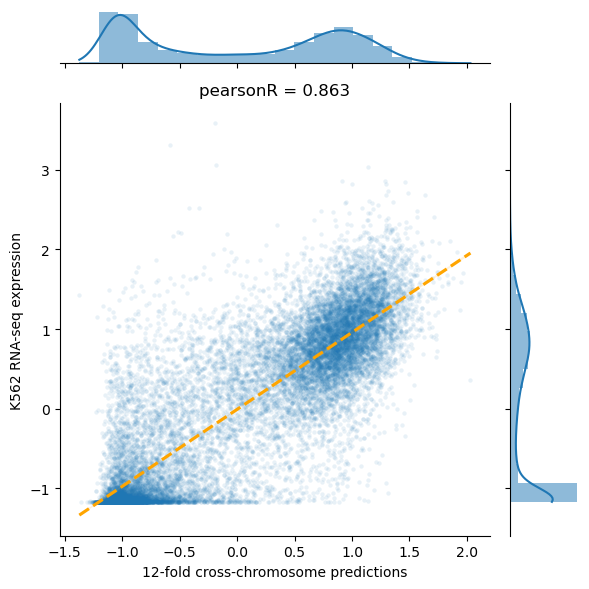

In [6]:
plt.figure(figsize=(6,6))
ax = sns.jointplot(
    data=prediction_res,
    x="Pred",
    y="actual",
    kind = 'scatter',
    joint_kws={'marker':'o', 's':10, 'alpha':0.1, 'linewidth':0},
    marginal_kws={'bins':20, 'element':'step', 'kde':True, 'linewidth':0},
)
ax.plot_joint(sns.regplot, color="r", scatter=False, line_kws={"color": "orange", 'linestyle':'dashed'})
plt.title('pearsonR = {:.3f}'.format(pearsonR))
plt.ylabel('K562 RNA-seq expression')
plt.xlabel('12-fold cross-chromosome predictions')
plt.tight_layout()

In [9]:
cell = 'GM12878'
distance_threshold = 100_000
n_enhancers = 60
device = 'cuda'
# num_feature == 1: distance; num_feature == 2: distance + enhancer activity; num_feature == 3: distance + enhancer activity + hic contacts
n_extraFeat = 3
batch_size = 16
expr_type = 'RNA'
prediction_res = []
for fi in range(1, 13):
    print("-"*10, 'fold', fi, '-'*10)
    fold_i = 'fold_' + str(fi)

    train_ensid = split_df[split_df[fold_i] == 'train'].index
    valid_ensid = split_df[split_df[fold_i] == 'valid'].index
    test_ensid = split_df[split_df[fold_i] == 'test'].index

    all_ds = train.promoter_enhancer_dataset(data_folder='data', expr_type=expr_type, cell_type=cell, n_extraFeat=n_extraFeat, n_enhancers=n_enhancers, distance_threshold=distance_threshold)
    ensid_list = [eid.decode() for eid in all_ds.data_h5['ensid'][:]]
    ensid_df = pd.DataFrame(ensid_list, columns=['ensid'])
    ensid_df['idx'] = np.arange(len(ensid_list))
    ensid_df = ensid_df.set_index('ensid')
    train_idx = ensid_df.loc[train_ensid]['idx']
    valid_idx = ensid_df.loc[valid_ensid]['idx']
    test_idx = ensid_df.loc[test_ensid]['idx']

    train_ds = Subset(all_ds, train_idx)
    valid_ds = Subset(all_ds, valid_idx)
    test_ds = Subset(all_ds, test_idx)

    model = EPInformer_v2(n_encoder=3, n_enhancer=n_enhancers, out_dim=64, n_extraFeat=n_extraFeat, device=device)
    checkpoint = torch.load("./trained_models/EPInformer_PE_Activity_HiC/GM12878/fold_{}_EPInformer_PE_Activity_HiC_{}_GM12878_checkpoint.pt".format(fi, expr_type), weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    test_df = train.test(model, test_ds, fold_i=fi, batch_size=batch_size, device=device)
    prediction_res.append(test_df)
prediction_res = pd.concat(prediction_res)

---------- fold 1 ----------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:35<00:00,  3.90it/s]


Pearson R: 0.8290492


PearsonR: 0.8290492
---------- fold 2 ----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:22<00:00,  3.71it/s]


Pearson R: 0.85802215


PearsonR: 0.85802215
---------- fold 3 ----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:20<00:00,  4.02it/s]


Pearson R: 0.88272667


PearsonR: 0.88272667
---------- fold 4 ----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:20<00:00,  4.20it/s]


Pearson R: 0.87623405


PearsonR: 0.87623405
---------- fold 5 ----------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:22<00:00,  4.86it/s]


Pearson R: 0.8019242


PearsonR: 0.8019242
---------- fold 6 ----------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:21<00:00,  5.41it/s]


Pearson R: 0.8157596


PearsonR: 0.8157596
---------- fold 7 ----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:09<00:00,  5.96it/s]


Pearson R: 0.87510306


PearsonR: 0.87510306
---------- fold 8 ----------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.49it/s]


Pearson R: 0.8428381


PearsonR: 0.8428381
---------- fold 9 ----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.77it/s]


Pearson R: 0.8768034


PearsonR: 0.8768034
---------- fold 10 ----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:12<00:00,  6.85it/s]


Pearson R: 0.8768529


PearsonR: 0.8768529
---------- fold 11 ----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:10<00:00,  7.06it/s]


Pearson R: 0.83523786


PearsonR: 0.83523786
---------- fold 12 ----------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.09it/s]



Pearson R: 0.8700684
PearsonR: 0.8700684


In [10]:
pearsonR, pv = stats.pearsonr(prediction_res['Pred'], prediction_res['actual'])
print('PearsonR of 12-fold cross-validation predicitons', pearsonR, 'Total genes:', len(prediction_res))

PearsonR of 12-fold cross-validation predicitons 0.8491912 Total genes: 18377


<Figure size 600x600 with 0 Axes>

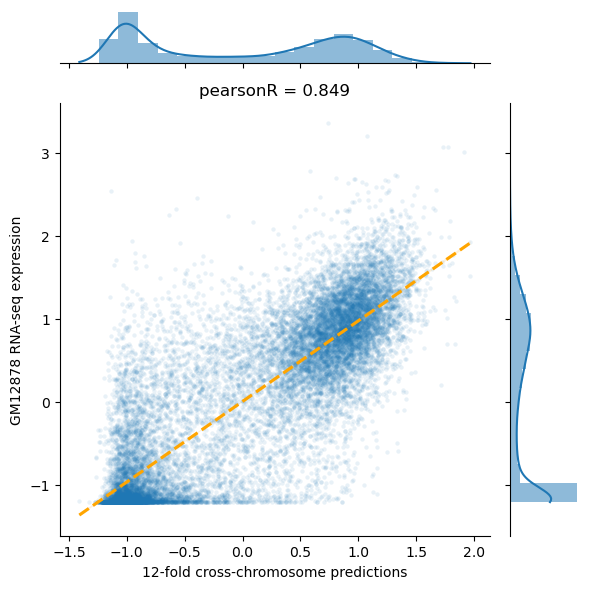

In [11]:
plt.figure(figsize=(6,6))
ax = sns.jointplot(
    data=prediction_res,
    x="Pred",
    y="actual",
    kind = 'scatter',
    joint_kws={'marker':'o', 's':10, 'alpha':0.1, 'linewidth':0},
    marginal_kws={'bins':20, 'element':'step', 'kde':True, 'linewidth':0},
)
ax.plot_joint(sns.regplot, color="r", scatter=False, line_kws={"color": "orange", 'linestyle':'dashed'})
plt.title('pearsonR = {:.3f}'.format(pearsonR))
plt.ylabel('GM12878 RNA-seq expression')
plt.xlabel('12-fold cross-chromosome predictions')
plt.tight_layout()

## Predict gene expression given promoter-enhancer sequence

In [8]:
# Donwload reference genome
!wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz  -P ./data/
!gunzip ./data/hg38.fa.gz

--2025-05-05 16:57:55--  https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘./data/hg38.fa.gz’

hg38.fa.gz          100%[===================>] 938,09M  16,8MB/s    in 59s     

2025-05-05 16:58:56 (15,9 MB/s) - ‘./data/hg38.fa.gz’ saved [983659424/983659424]



In [12]:
# Load ABC enhancer-gene data
enhancer_gene_k562 = pd.read_csv('./data/K562_DNase_ENCFF257HEE_hic_4DNFITUOMFUQ_1MB_ABC_nominated/Gene-enhancer links/EnhancerPredictionsAllPutative.txt.gz', sep='\t')
# Select the gene-enhancer links within 100kb to the TSS of target gene and remove the promoter element
enhancer_gene_k562_100kb = enhancer_gene_k562[(enhancer_gene_k562['distance']<=100_000)&(enhancer_gene_k562['distance']>1000)].reset_index()
enhancer_gene_k562_100kb.to_csv('./data/K562_enhancer_gene_links_100kb.tsv', index=False, sep='\t')

In [13]:
enhancer_gene_k562_100kb = pd.read_csv('./data/K562_enhancer_gene_links_100kb.tsv', sep='\t')
gene_tss = pd.read_csv('./data/K562_DNase_ENCFF257HEE_hic_4DNFITUOMFUQ_1MB_ABC_nominated/DNase_ENCFF257HEE_Neighborhoods/GeneList.txt', sep='\t')[['name', 'chr', 'tss', 'strand']]
data_split = pd.read_csv('./data/leave_chrom_out_crossvalidation_split_18377genes.csv')
gene_tss = gene_tss.merge(data_split[['ENSID', 'Gene name']], left_on='name', right_on='ENSID').drop(columns='name')
enhancer_gene_k562_100kb_includeNoEnhancerGene = enhancer_gene_k562_100kb.merge(gene_tss, left_on='TargetGene', right_on='ENSID', how='right', suffixes=['', '_gene']).reset_index()

In [14]:
enhancer_gene_k562_100kb_includeNoEnhancerGene.head(3)

,level_0,index,chr,start,end,name,class,activity_base,TargetGene,TargetGeneTSS,...,ABC.Score.Numerator,ABC.Score,powerlaw.Score.Numerator,powerlaw.Score,CellType,chr_gene,tss,strand,ENSID,Gene name
0,0,355555.0,chrX,100671069.0,100671638.0,genic|chrX:100671069-100671638,genic,0.191760,ENSG00000000003,100636750.0,...,0.485751,0.008531,0.004399,0.018000,K562,chrX,100636750,-,ENSG00000000003,TSPAN6
1,1,355579.0,chrX,100674734.0,100675481.0,genic|chrX:100674734-100675481,genic,0.397338,ENSG00000000003,100636750.0,...,1.176227,0.020658,0.008333,0.034101,K562,chrX,100636750,-,ENSG00000000003,TSPAN6
2,2,355603.0,chrX,100685550.0,100686167.0,genic|chrX:100685550-100686167,genic,0.555460,ENSG00000000003,100636750.0,...,1.509652,0.026514,0.009396,0.038451,K562,chrX,100636750,-,ENSG00000000003,TSPAN6


In [15]:
gene_info = data_split[data_split['fold_1'] == 'test'][['ENSID', 'Gene name']].head(16).reset_index(drop=True)
gene_list = list(gene_info['ENSID'])
# encode gene-enhancer links for EPInformer
# num_feature == 1: distance; num_feature == 2: distance + enhancer activity; num_feature == 3: distance + enhancer activity + hic contacts
device = 'cpu'
PE_codes, PE_feats, mRNA_feats, PE_pairs = prepare_input(enhancer_gene_k562_100kb_includeNoEnhancerGene, gene_list, 'K562', num_features=2)
PE_codes = torch.from_numpy(PE_codes).float().to(device)
PE_feats = torch.from_numpy(PE_feats).float().to(device)
mRNA_feats = torch.from_numpy(mRNA_feats).float().to(device)
print(PE_codes.shape, PE_feats.shape, mRNA_feats.shape)

  0%|                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.03it/s]

torch.Size([16, 61, 2000, 4]) torch.Size([16, 61, 2]) torch.Size([16, 9])


In [16]:
# Load pre-trained EPInformer-PE-Activity (CAGE-seq)
expr_type = 'CAGE'
model = EPInformer_v2(n_encoder=3, n_enhancer=60, out_dim=64, n_extraFeat=2, device=device)
model_path = './trained_models/EPInformer_PE_Activity/K562/fold_1_EPInformer_PE_Activity_{}_K562_checkpoint.pt'.format(expr_type)
checkpoint = torch.load(model_path, map_location=torch.device(device), weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

In [17]:
model.eval()
with torch.no_grad():
    pred_expr, _ = model(PE_codes, mRNA_feats, PE_feats)
    pred_expr = pred_expr.numpy().squeeze()
gene_info['predicted_expr'] = pred_expr
gene_info['expr_type'] = expr_type

In [18]:
gene_info

,ENSID,Gene name,predicted_expr,expr_type
0,ENSG00000002016,RAD52,1.913353,CAGE
1,ENSG00000003056,M6PR,2.470468,CAGE
2,ENSG00000003137,CYP26B1,1.000790,CAGE
3,ENSG00000003393,ALS2,1.903482,CAGE
4,ENSG00000003400,CASP10,0.779036,CAGE
5,ENSG00000003402,CFLAR,1.895073,CAGE
6,ENSG00000003436,TFPI,1.848657,CAGE
7,ENSG00000003509,NDUFAF7,2.525692,CAGE
8,ENSG00000004478,FKBP4,1.874264,CAGE
9,ENSG00000004700,RECQL,2.110345,CAGE
